#***Quora Question Pairing***

##***Understanding the Business Problem***

###*Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world. Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.*

###*Problem Statement :*

1.   *Identify which questions asked on Quora are duplicates of questions that have already been asked.*
2.   *This could be useful to instantly provide answers to questions that have already been answered.*
3.   *We are tasked with predicting whether a pair of questions are duplicates or not.*

##***Relevant URL and Source of Data***

###*Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges. Entire data has been taken from Kaggle.com. Source URL : https://www.kaggle.com/c/quora-question-pairs*

##***As a Machine Learning Challenge***

###*It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. Below is the Data Overview :*
1.   *Number of rows in the data set = 404,290*
2.   *Each row has 5 columns : qid1, qid2, question1, question2,is_duplicate* 

###*Performance Metric : Log Loss and Binary Confusion Matrix*

###*Train and Test Construction : We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.*



##***Exploratory Data Analysis***

In [ ]:
#importing all the relevant modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#loading the data set using drive function of google colab
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/My\ Drive/Colab Notebooks

In [ ]:
#uploading the data set and publishing the number of rows
df = pd.read_csv("Quora_Train_Dataset.csv")
print("Number of data points : ",df.shape[0])

Number of data points :  404290


In [ ]:
#publishing top rows of the table
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
#publishing basic info about the table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


###***Distribution of data points among output classes***

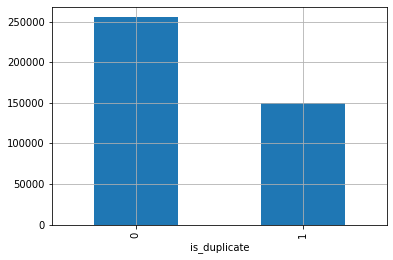

In [ ]:
#understanding the distribution of class label in data through bar graph
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.grid()
plt.show()

In [ ]:
#publishing the percentage wise distribution of class label
print('Total number of question pairs for training         :   {}'.format(len(df)))
print('Question pairs are not Similar (is_duplicate = 0)   :   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1)       :   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training         :   404290
Question pairs are not Similar (is_duplicate = 0)   :   63.08%
Question pairs are Similar (is_duplicate = 1)       :   36.92%


###***Number of unique questions***

In [ ]:
#understanding the total number of unique questions in the data set
qids                  =  pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs             =  len(np.unique(qids))
qs_morethan_onetime   =  np.sum(qids.value_counts() > 1)
print('Total number of  Unique Questions are                     : {}'.format(unique_qs))
print('Number of unique questions that appear more than one time : {} ({}%)'.format(qs_morethan_onetime,round(qs_morethan_onetime/unique_qs*100,2)))
print('Maximum number of times a single question is repeated     : {}'.format(max(qids.value_counts()))) 
q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are                     : 537933
Number of unique questions that appear more than one time : 111780 (20.78%)
Maximum number of times a single question is repeated     : 157


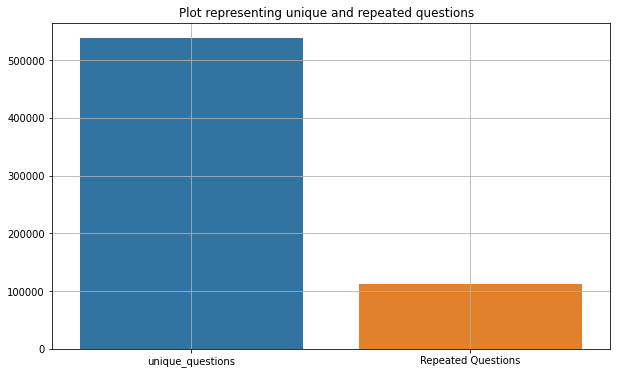

In [ ]:
#plotting the bar graph for number of question that are unique and that are repeated
x = ["unique_questions","Repeated Questions"]
y = [unique_qs,qs_morethan_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.grid()
plt.show()

###***Checking for Duplicates***

In [ ]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate pair of questions : ",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate pair of questions :  0


###***Number of occurrences of each question***

Maximum number of times a single question is repeated : 157



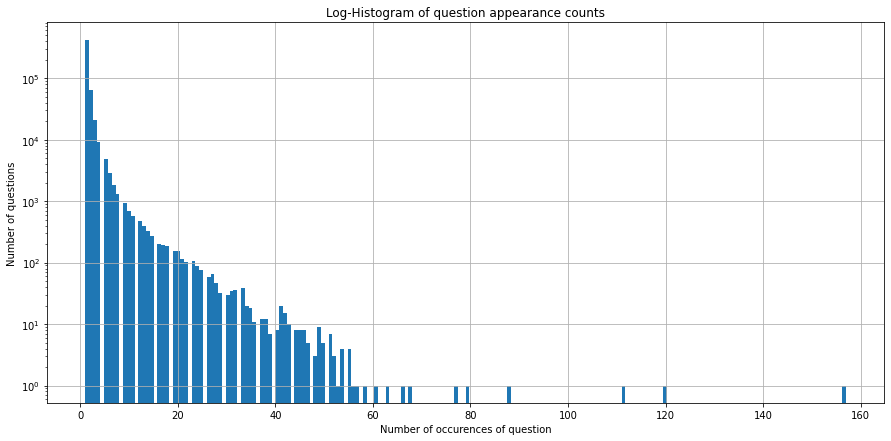

In [ ]:
#plotting log of number of questions vs frequency of the question
plt.figure(figsize=(15,7))
plt.hist(qids.value_counts(), bins=200)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print('Maximum number of times a single question is repeated : {}\n'.format(max(qids.value_counts()))) 
plt.grid()
plt.show()

###***Checking for NULL values***

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
#Filling the null values with ''
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate


###***Basic Feature Extraction before cleaning Data***

***Let us now construct a few features like :*** 
 - ____freq_qid1____    = Frequency of qid1's
 - ____freq_qid2____    = Frequency of qid2's 
 - ____q1len____        = Length of q1
 - ____q2len____        = Length of q2
 - ____q1_n_words____   = Number of words in Question 1
 - ____q2_n_words____   = Number of words in Question 2
 - ____word_Common____  = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____   =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____   = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
#extracting the features as mentioned above
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1']   = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2']   = df.groupby('qid2')['qid2'].transform('count')
    df['q1len']       = df['question1'].str.len() 
    df['q2len']       = df['question2'].str.len()
    df['q1_n_words']  = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words']  = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

In [ ]:
#publishing top few rows of updated DataFrame
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


###***Analysis of some of the extracted features***

In [ ]:
#Number of questions in Q1 ands Q2 in pair with Maximum and Minimum words
print ("Minimum length of the questions in question1        :", min(df['q1_n_words']))
print ("Minimum length of the questions in question2        :", min(df['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])
print('='*60)
print ("Maximum length of the questions in question1        :", max(df['q1_n_words']))
print ("Maximum length of the questions in question2        :", max(df['q2_n_words']))
print ("Number of Questions with maximum length [question1] :", df[df['q1_n_words']== 125].shape[0])
print ("Number of Questions with maximum length [question2] :", df[df['q2_n_words']== 237].shape[0])

Minimum length of the questions in question1        : 1
Minimum length of the questions in question2        : 1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24
Maximum length of the questions in question1        : 125
Maximum length of the questions in question2        : 237
Number of Questions with maximum length [question1] : 1
Number of Questions with maximum length [question2] : 13


###***Feature: word share***

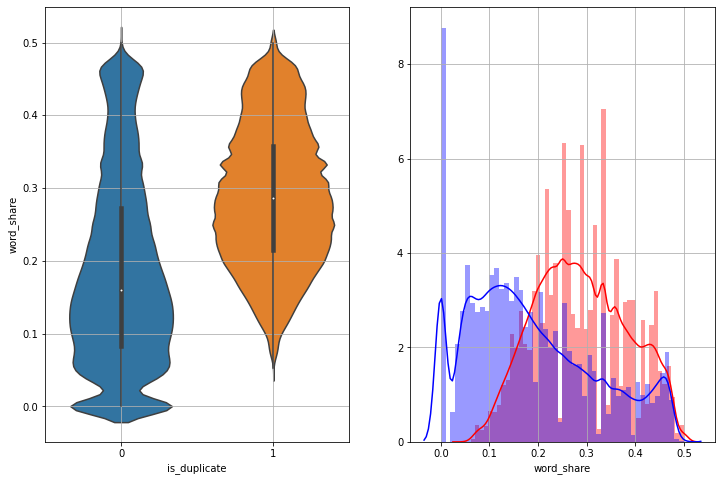

In [ ]:
#plottinng the violin plot and the distribution graph
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])
plt.grid()
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:],label="1",color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:],label="0",color='blue')
plt.grid()
plt.show()

***Observations :***


1.   __The distributions for normalized word_share have some overlap on the far right-hand side.__
2.   __The average word share and common number of words of qid1 and qid2 is more when they are duplicate(Similar).__






###***Feature: word common***

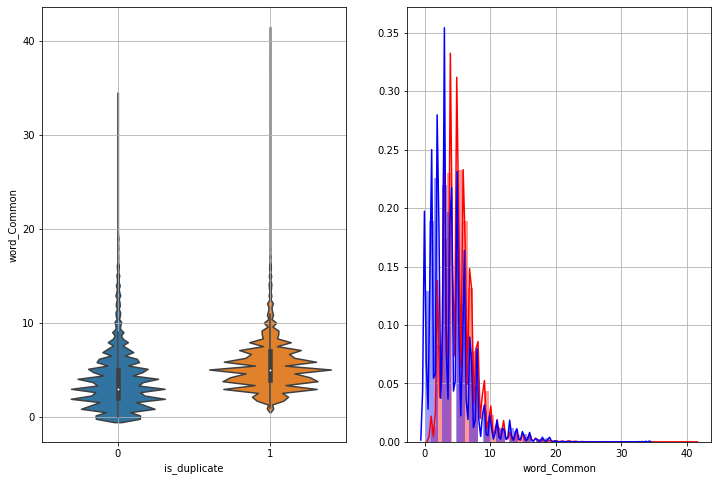

In [ ]:
#plottinng the violin plot and the distribution graph
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common',data=df[0:])
plt.grid()
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.grid()
plt.show()

***Observation :***


1.   __The distributions of the word_Common feature in similar and non-similar questions are highly overlapping.__

###***-- End of Notebook 1 --***